# INF391 - Tarea 4
Se tienen dos conjuntos de 100 objetos cada uno, todos ubicados dentro de un cuadrado unitario en el eje cartesiano (2-d). El primer conjunto está distribuido de manera uniforme y el segundo fue generado aleatoriamente.


1. En términos de densidad, ¿qué diferencia existe entre los dos conjuntos?.
2. ¿Qué conjunto tiene menor SSE para $K=10$ clusters?.
3. Muestre y comente el comportamiento de DBSCAN en cada conjunto de datos.


In [1]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from numpy import genfromtxt,zeros_like,linspace
import matplotlib.pyplot as plt

In [2]:
random = genfromtxt('random.csv', delimiter=',')
uniform = genfromtxt('uniform.csv', delimiter=',')

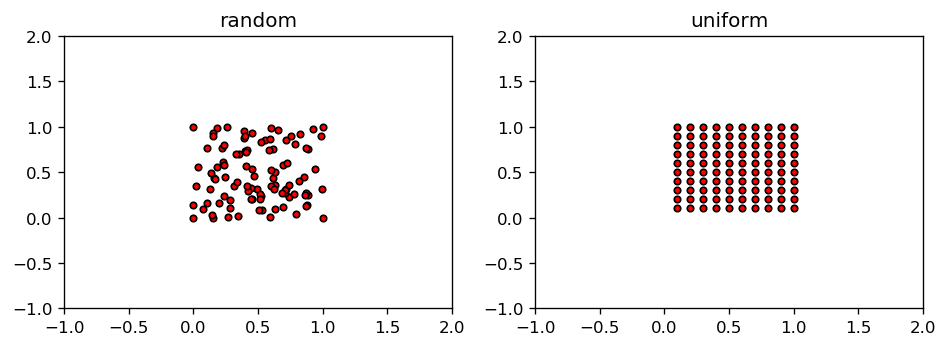

In [3]:
# Crear Figuras
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3), dpi=120)

# Plot
ax1.scatter(random[:,0], random[:,1], s=15, facecolors = 'red', edgecolors = "black")  
ax2.scatter(uniform[:,0], uniform[:,1], s=15, facecolors = 'red', edgecolors = "black") 

ax1.set_title('random')
ax2.set_title('uniform')

ax1.set_xlim((-1,2))
ax1.set_ylim((-1,2))

ax2.set_xlim((-1,2))
ax2.set_ylim((-1,2))

plt.tight_layout()
plt.show()

# Desarrollo

> En términos de densidad, ¿qué diferencia existe entre los dos conjuntos?.

Consideramos como estimador de densidad al método que cuenta la cantidad de puntos cercanos respecto a otro dado un radio; 

Si aplicamos este método con un radio igual 0.1, nos daremos cuenta que en el primer data set `random` tiene ciertas vecindades que poseen una mayor cantidad de puntos dentro del radio, y otras con menores cantidades de puntos. Sin embargo, el segundo data set, al ser uniforme en su distribución, da lo mismo que punto tomar (excluyendo los casos de borde), siempre existirá la misma cantidad de puntos en la vecindad. Por lo que si existen diferencias en como se distribuyen estos data set.

> ¿Qué conjunto tiene menor SSE para $K=10$ clusters?.

Consideremos que por definición, la suma de los errores cuadráticos es:
$$
SSE = \sum^{K}_{i=1}\sum_{x\in C_i}\text{dist}(c_i,x)^2
$$
Con $x$ el objeto a evaluar, $c_i$ el centroide del cluster $C_i$.

Ahora consideremos la distribucion visible de los datos. En el dataset `random`, no existe una distribución uniforme que modele los datos, a diferencia del dataset `uniform`. Si consideramos un algoritmos para cluster prototype-based, como K-Means, nos daremos cuenta que los objetos tendrán una menor distancia con respecto a su centroide si los datos están altamente condensados.

Para comprobar esto, basta con obtener el $SSE$ obtenido al aplicar la función `KMeans` sobre los dataset:

In [4]:
from sklearn. cluster import KMeans

model_random = KMeans(n_clusters=10).fit(random)
model_uniform = KMeans(n_clusters=10).fit(uniform)

print("|SSE para random: %f |SSE para uniform: %f |" % (model_random.inertia_,model_uniform.inertia_))

|SSE para random: 1.507832 |SSE para uniform: 1.660184 |


Se puede observar que el $SSE$ asociado al dataset `random` es menor al $SSE$ del dataset `uniform`, validando nuestra respuesta.

> Muestre y comente el comportamiento de DBSCAN en cada conjunto de datos.

In [5]:
def fixed_DBSCAN(data_set, Eps, MinPts, ax=None):
    if ax is None:
        ax = plt.gca()
    ## Model 
    model = DBSCAN(eps=Eps, min_samples=MinPts).fit(data_set)
    core_samples_mask = zeros_like(model.labels_, dtype=bool)
    core_samples_mask[model.core_sample_indices_] = True
    labels = model.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # Plot
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = data_set[class_member_mask & core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k')

        xy = data_set[class_member_mask & ~core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k')
        
    ax.set_title("""Estimated number of clusters: %d\nEstimated number of noise points: %d\n (Eps= %f) and (MinPts=%d)"""
                 % (n_clusters_,n_noise_,Eps, MinPts),fontsize = 7)

Para evaluar la densidad en los data set usando DBSCAN, vamos a considerar un $Eps=0.1$ y un conjunto de $MinPts$ con los valores del 1 al 6.

## DBSCAN en `random`

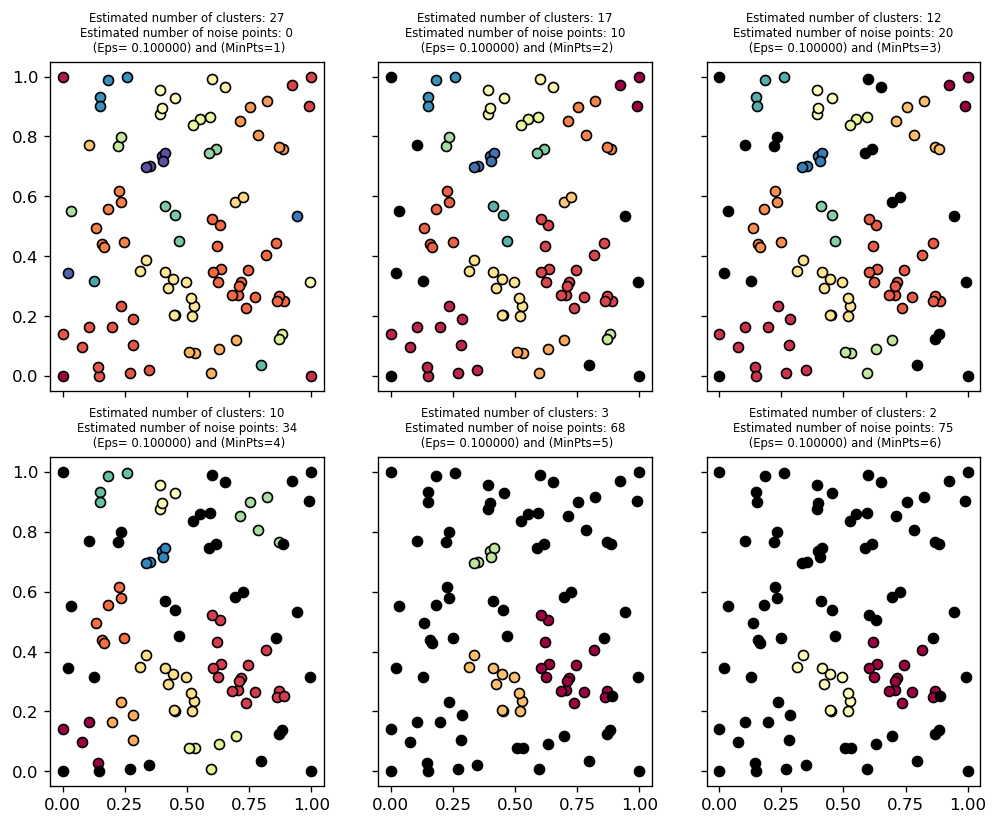

In [6]:
f, axs = plt.subplots(2,3, figsize=(10,8), dpi=120)
k=1
for i in range(0,2):
    for j in range(0,3):
        fixed_DBSCAN(random, 0.1, k, axs[i,j])
        k+=1
        
for ax in axs.flat:
    ax.label_outer()    
plt.show()

## DBSCAN en `uniform`

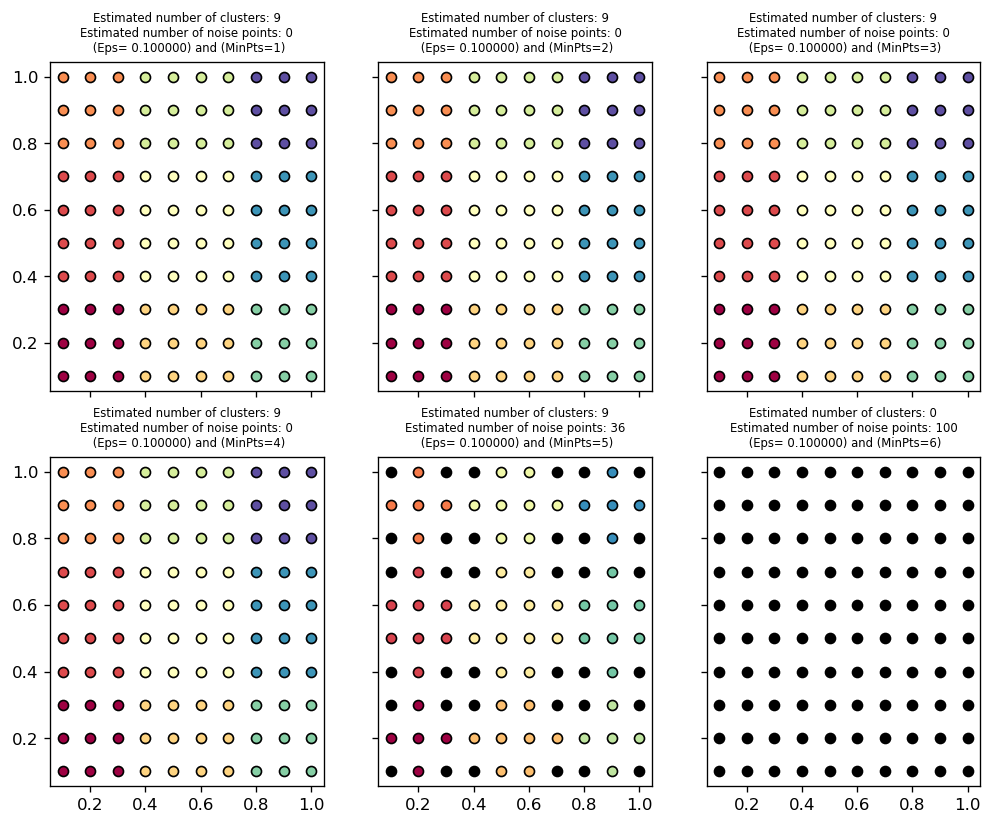

In [7]:
f, axs = plt.subplots(2,3, figsize=(10,8), dpi=120)
k=1
for i in range(0,2):
    for j in range(0,3):
        fixed_DBSCAN(uniform, 0.1, k, axs[i,j])
        k+=1
        
for ax in axs.flat:
    ax.label_outer()    
plt.show()

### Análisis

De acuerdo a las consideraciones tomadas al principio, como fijar el $Eps=0.1$ y definir un conjunto de $MinPts$ que va del 1 al 6, y dadas las dos figuras anteriores con 6 gráficos por cada data set, se tiene:

* Para el conjunto `random`, se observa que con $MinPts=1$ existen 27 clusters y hay una ausencia de Noise Points, sin embargo, a medida que va creciendo el número de $MinPts$ va decreciendo la cantidad de clusters encontrados (siempre manteniendo el valor de $Eps$ constante en $0.1$). Para entender esto, consideremos la métrica $k$-dist como la distancia entre un punto con su $k_{th}$ vecino más cercano. Ahora, el valor entregado por $k$-dist será pequeño si $k$ no es mayor que el tamaño del grupo. Luego, si asignamos el valor optimo de $k$-dist a $Eps$ y el de $k$ al de $MinPts$, tendremos que los puntos para los que $k$-dist es menor que $Eps$ serán Core Points, mientra que los demás serán Noise points o Border points. Por lo tanto a medida que crece nuestro vecindario, se reducirán los cluster dada la condición anterior. Prevaleciendo los de mayor densidad.

* Para el conjunto `uniform`, se observa una disidencia en el calculo de los clusters, dado que al prevalecer una distribución uniforme por sobre regiones con alta densidad, los Core Points dejan existir de forma abrupta dada la condición anteriormente explicada con $k$-dist. Por lo tanto la uniformidad de los datos hacen que los cambios de cluster encontrados por DBSCAN sean más abruptos e ineficientes debido a la falta de densidad en la muestra. Esto se puede ver reflejado en los gráficos 5 y 6 de la ultima figura.